In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 28.1 MB/s 
     |████████████████████████████████| 182 kB 79.9 MB/s 
     |████████████████████████████████| 7.6 MB 65.5 MB/s 


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import warnings
warnings.filterwarnings('ignore')


In [4]:
# 코랩 사용 시 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# df = pd.read_csv('./data/review_data_f.csv')
df = pd.read_csv('/content/drive/MyDrive/공장/review_data_f.csv')
df = df[['review', 'y']]
# df.rename(columns={'review':'0', 'y':'1'}, inplace=True)
df

,review,y
0,3대째 이어오고 있는 춘천시 소양로 2가에 위치한 막국수 전문점. 숨은 맛 집답게 ...,1
1,공간이 많이 좁았지만 햇살이 잘 들어와서 너무 이뻤던 카페입니다 레몬 빵이 시큼하고...,1
2,비싸고 맛없어요!,0
3,아기자기하고 이쁜 곳! 맛도 좋다!! 배도 부르다! 일요일 점심 무더위에도 웨이팅을...,1
4,막걸리 비싸고 주인장의 고압적인 응대에 위축되고 테이블은 다닥다닥 붙어있고 술 마시...,0
...,...,...
2062,웬만하면 리뷰 안다는데 개만 없고 개비 싸고 개불 친절함,0
2063,양념이 좀 많이 달아요. 육수는 조미료 맛 많이 나서 별로예요. 직접 면을 뽑는 ...,0
2064,근처 맛 집 검색해서 찾아가 봤어요 음식이 전체적으로 다 맛있네요 깔끔한 내부도 마...,1
2065,최악 여길 왜가는지 모르겠음. 마늘 손질하던 아줌마가 카드 계산하고 다시 가서 마늘...,0


In [6]:
df['y'].value_counts()

0    1042
1    1025
Name: y, dtype: int64

In [7]:
# 미리 학습된 토크나이저 불러오기 
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def encode(sents, tokenizer):
    input_ids = [] # 각 문서를 구성하는 토큰의 ID 정보를 저장하는 리스트
    attention_masks = [] # 각 문서의 어텐션 마스크 정보를 저장하는 리스트
    for text in sents:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=30,    # 문서 길이 30으로 통일
                                            add_special_tokens = True,    #[CLS], [SEP] 토큰 추가
                                            pad_to_max_length=True, 
#                                             padding_side='right',
                                            return_attention_mask=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
    
    return tf.convert_to_tensor(input_ids, dtype=tf.int32), tf.convert_to_tensor(attention_masks, dtype=tf.int32)

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [8]:
tokenized_sents = encode(df['review'], tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [9]:
# 첫번째 리뷰의 토큰 ID 정보 
tokenized_sents[0][0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([  101,   124, 14423, 93119, 64749, 28188, 11664, 13767,  9767,
       38631, 14040,  9448, 37114, 11261,   123, 11287, 10530, 39828,
        9247, 20479, 15891,  9665, 25934, 34907,   119,  9464, 10892,
        9254,  9711,   102], dtype=int32)>

In [10]:
# 첫번째 리뷰의 attention mask
tokenized_sents[1][0]

<tf.Tensor: shape=(30,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)>

In [11]:
model = TFBertModel.from_pretrained('bert-base-multilingual-cased', output_hidden_states = True)

Downloading:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [12]:
for layer in model.layers:
    layer.trainable=False

In [13]:
# with tf.device('/GPU:0'):
outputs = model(tokenized_sents[0], attention_mask = tokenized_sents[1])

In [14]:
hidden_states = outputs.hidden_states

In [15]:
#마지막 인코더 블록의 정보만 사용 
hidden_states[-1]
hidden_states[-1].shape

# TensorShape([545, 30, 768])
# 545 = 리뷰의 수
# 30 = 각 리뷰를 구성하는 토큰 수
# 768 = 각 토큰을 구성하는 벡터 차원

TensorShape([2067, 30, 768])

In [16]:
# CLS 토큰만 선택해서 numpy 배열로 -->독립변수 
features = hidden_states[-1][: ,0 , :].numpy()
features.shape

(2067, 768)

In [17]:
features

array([[-0.06319331,  0.00803359, -0.27090016, ...,  0.15440598,
         0.21793804,  0.0412458 ],
       [-0.02704326, -0.07928081, -0.33077586, ...,  0.02262093,
         0.04431517,  0.10466912],
       [-0.15022825, -0.0659401 , -0.09584871, ...,  0.46479803,
         0.11947191,  0.29292515],
       ...,
       [-0.0217619 ,  0.0793658 ,  0.19324125, ...,  0.20927523,
         0.06323078,  0.05348302],
       [ 0.16000137, -0.107111  , -0.14419645, ...,  0.3060035 ,
         0.1438604 ,  0.16176757],
       [-0.04792608, -0.08633424, -0.27390414, ...,  0.32288545,
         0.15221852, -0.00676434]], dtype=float32)

In [18]:
#종속변수 지정 
selected_labels = df['y']

In [19]:
#train/test 나누기 
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, selected_labels, test_size=0.2, random_state=0)

In [20]:
#로지스틱 회귀 학습
from sklearn.linear_model import LogisticRegression

lr2 = LogisticRegression(C=0.1, penalty='l2', solver='saga', max_iter=1000)
lr2.fit(train_features, train_labels)
pred_labels = lr2.predict(test_features)

In [21]:
# 정확도 계산 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#accuracy_score(test_labels, pred_labels)
#confusion_matrix(test_labels, pred_labels)
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       218
           1       0.69      0.69      0.69       196

    accuracy                           0.70       414
   macro avg       0.70      0.70      0.70       414
weighted avg       0.70      0.70      0.70       414



In [22]:
accuracy_score(test_labels, pred_labels)

0.7028985507246377

In [23]:
review = df['review']
y = df['y']

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(review, y, random_state=42, test_size=0.2)

In [25]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def encode(data, tokenizer):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=50,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True,
                                            truncation=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])
    
    return input_ids, attention_masks, token_type_ids

In [26]:
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer)

#테스트 데이터
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer)

In [27]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
        }, label


def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)
    
BATCH_SIZE = 32
    
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).shuffle(10000).batch(BATCH_SIZE)
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)

In [30]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2
)


optimizer = tf.keras.optimizers.Adam(1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

NUM_EPOCHS = 30
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
52/52 [==============================] - 39s 432ms/step - loss: 0.6638 - accuracy: 0.5977 - val_loss: 0.5377 - val_accuracy: 0.7488
Epoch 2/30
52/52 [==============================] - 20s 378ms/step - loss: 0.5348 - accuracy: 0.7453 - val_loss: 0.4581 - val_accuracy: 0.7947
Epoch 3/30
52/52 [==============================] - 20s 385ms/step - loss: 0.4294 - accuracy: 0.8094 - val_loss: 0.4664 - val_accuracy: 0.7826
Epoch 4/30
52/52 [==============================] - 20s 384ms/step - loss: 0.3623 - accuracy: 0.8554 - val_loss: 0.4168 - val_accuracy: 0.8164
Epoch 5/30
52/52 [==============================] - 20s 387ms/step - loss: 0.2600 - accuracy: 0.9062 - val_loss: 0.4299 - val_accuracy: 0.8237
Epoch 6/30
52/52 [==============================] - 20s 389ms/step - loss: 0.1795 - accuracy: 0.9395 - val_loss: 0.4844 - val_accuracy: 0.8237
Epoch 7/30
52/52 [==============================] - 20s 391ms/step - loss: 0.1440 - accuracy: 0.9522 - val_loss: 0.5534 - val_accuracy: 0.8092

In [33]:
model.save_weights("/content/drive/MyDrive/공장/bert_model.h5")

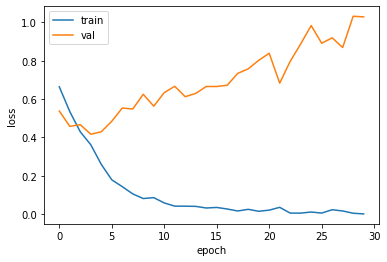

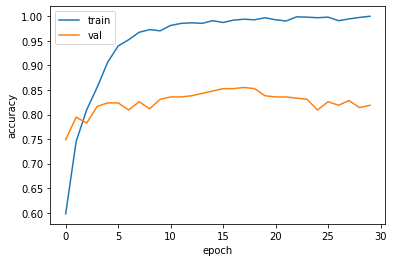

In [31]:
# loss 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()


# accuracy 확인 
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()